# RNN model with MNIST dataset

## 1. import package

In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Set hyperparameters

In [2]:
learning_rate = 0.001
batch_size = 128
epochs = 50

## 3. Load data and preprocess

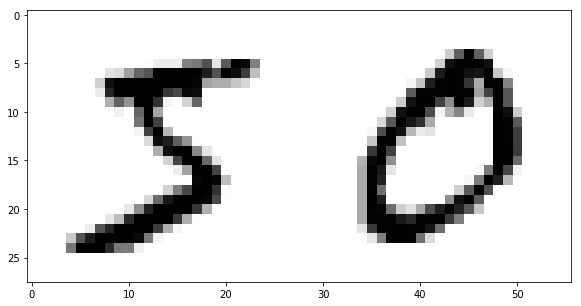

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.figure(figsize=(10,5))
img1 = X_train[0]
img2 = X_train[1]
img = np.concatenate((img1,img2),axis=1)  
plt.imshow(img, cmap='binary')
plt.show()

In [4]:
X_train = X_train / 255.
X_test = X_test / 255.
y_train = np.eye(10)[y_train[:]]
y_test = np.eye(10)[y_test[:]]

In [5]:
def batch_gen(X, y, batch_size):
    X1, y1 = shuffle(X, y)
    X2, y2 = shuffle(X, y)  
    batch_index = 0
    while(batch_index < len(X)):
        batch_X1 = X1[batch_index : batch_index+batch_size]
        batch_X2 = X2[batch_index:batch_index+batch_size]
        batch_X = np.concatenate((batch_X1, batch_X2), axis=2) 
        
        batch_y1 = y1[batch_index : batch_index+batch_size]
        batch_y2 = y2[batch_index : batch_index+batch_size]
        batch_index += batch_size
        yield batch_X, batch_y1, batch_y2

## 4. Build the graph

In [6]:
def RNN_layer(inputs, units):
    BasicRNN_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=units)
    init_state = BasicRNN_cell.zero_state(tf.shape(inputs)[0], dtype=tf.float32)
    outputs, states = tf.nn.dynamic_rnn(BasicRNN_cell, inputs, initial_state=init_state)
    
    return outputs

In [7]:
tf.reset_default_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32,[None, 28, 56], name='X')
    y1 = tf.placeholder(tf.float64,[None, 10], name='y1')
    y2 = tf.placeholder(tf.float64,[None, 10], name='y2')

with tf.variable_scope("RNN_layer"):
    outputs = RNN_layer(X, 32)   

with tf.variable_scope("output_layer"):
    RNN_last_outputs = outputs[:,-1,:]  
    prediction1 = tf.layers.dense(inputs=RNN_last_outputs, units=10)
    prediction2 = tf.layers.dense(inputs=RNN_last_outputs, units=10)

with tf.name_scope("loss"):
    loss1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction1,labels=y1))
    loss2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction2,labels=y2))
    loss = loss1 + loss2

with tf.name_scope("optimizer"):
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

with tf.name_scope("accuracy"):
    correct_prediction=tf.logical_and(tf.equal(tf.argmax(prediction1,1),tf.argmax(y1,1)),
                                      tf.equal(tf.argmax(prediction2,1),tf.argmax(y2,1)))
    accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))      

init = tf.global_variables_initializer()

In [8]:
tf.global_variables()

[<tf.Variable 'RNN_layer/rnn/basic_rnn_cell/kernel:0' shape=(88, 32) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense/kernel:0' shape=(32, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense_1/kernel:0' shape=(32, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense_1/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'optimizer/beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'optimizer/beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/kernel/Adam:0' shape=(88, 32) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/kernel/Adam_1:0' shape=(88, 32) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/bias/Adam:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/bias/Adam_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Vari

## 5. Train the model

In [9]:
sess = tf.Session()
sess.run(init)

In [10]:
for epoch_index in range(epochs):
    loss_ls, acc_ls = [], []
    get_batch = batch_gen(X_train, y_train, batch_size)
    
    for batch_X, batch_y1, batch_y2 in get_batch:
        _,  batch_acc, batch_loss = sess.run([opt, accuracy, loss], feed_dict={X: batch_X, y1:batch_y1, y2:batch_y2})
        loss_ls.append(batch_loss)
        acc_ls.append(batch_acc)
        
    if epoch_index%5 == 0:
        print("Epoch ", epoch_index)
        print("Accuracy ", np.mean(acc_ls), "     Loss ", np.mean(loss_ls))
        print("__________________")    

Epoch  0
Accuracy  0.15772699      Loss  3.4050841
__________________
Epoch  5
Accuracy  0.4910048      Loss  1.7695117
__________________
Epoch  10
Accuracy  0.5768035      Loss  1.4425137
__________________
Epoch  15
Accuracy  0.632496      Loss  1.2425057
__________________
Epoch  20
Accuracy  0.667916      Loss  1.1277943
__________________
Epoch  25
Accuracy  0.70654535      Loss  1.0257676
__________________
Epoch  30
Accuracy  0.7374178      Loss  0.93321425
__________________
Epoch  35
Accuracy  0.76644677      Loss  0.8453826
__________________
Epoch  40
Accuracy  0.7802672      Loss  0.7911975
__________________
Epoch  45
Accuracy  0.7904229      Loss  0.7547878
__________________


In [11]:
test_X1 = X_test[:500]
test_X2 = X_test[500:1000]
test_X = np.concatenate((test_X1, test_X2), axis=2) 
test_y1 = y_test[:500]
test_y2 = y_test[500:1000]

print("Testing Accuracy:", sess.run(accuracy, feed_dict={X: test_X, y1: test_y1, y2:test_y2}))

Testing Accuracy: 0.792


In [12]:
sess.close()